# Set-to-set Prediction with DETR
Start with imports

In [1]:
import os
from random import random, randint, seed
from math import pi, cos, sin, floor, ceil

from tqdm import tqdm
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

## Simulation Environment
Build a simulation environment. We need the enviroment to have the following properties:

 - Object based representations.
 - Number of object can decrease/increase (and can be predicted).
 - Respond to actions.
 - (Optional) Objects needs to have hidden attributes.

### Object Class
A simulated object that moves inside a field and appear on the other side when colliding with the boundaries.

In [2]:
class Object():
  def __init__(self, env_width, env_height, id, state=None):
    # attributes of the scene
    self.ENV_H = env_height
    self.ENV_W = env_width

    if state is None:
      # random seed
      seed(int.from_bytes(os.urandom(4), byteorder='little'))
      
      # default spawned location
      self.x = self.ENV_W * random()
      self.y = self.ENV_H * random()

      # default velocity
      self.theta = random() * 2.0 * pi
      self.v = random() * (self.ENV_W + self.ENV_H) / 30.0

      # default mass
      self.m = random()

    else:
      # otherwise spawned at the specified state
      self.x, self.y, self.theta, self.v, self.m = state

    self.lifespan = 0
    self.id = id
  

  def step(self):
    # moving forward
    self.x += cos(self.theta) * self.v
    self.y += sin(self.theta) * self.v

    # move to the other side if exceeding boundaries
    self.x = self.x % self.ENV_W
    self.y = self.y % self.ENV_H

    # update lifespan
    self.lifespan += 1


  @property
  def state(self):
    return np.array([self.x, self.y, self.theta, self.v, self.m, self.lifespan, self.id])


  def __str__(self):
    return self.state

### Environment

Action: [0, 1, 2]

- 0: Does Nothing.

- 1: Spawn an object at the average location of all objects.

- 2: Remove the object closer to the middle.

In [3]:
class Environment():
  def __init__(self, num_obj, env_width = 640, env_height = 480):
    self.MAX_OBJ = 100

    self.ENV_W = env_width
    self.ENV_H = env_height

    self.num_obj = num_obj
    self.objs = [Object(env_width, env_height, i) for i in range(num_obj)]
    self.id_max = num_obj


  def step(self, action):
    # first move every objects
    for i in range(self.num_obj):
      self.objs[i].step()

    if action != 0:
      # spawn or remove objects
      avg_loc, center_obj = self.find_center_obj()

      if action == 1:
        # determine the state of the new object
        new_obj_loc = avg_loc
        new_obj_attri = center_obj.state[2:5]
        new_obj_state = new_obj_loc.tolist() + new_obj_attri.tolist()

        # update
        self.objs.append(Object(self.ENV_W,
                                self.ENV_H,
                                self.id_max,
                                state = new_obj_state))
        self.num_obj += 1
        self.id_max += 1

      elif action == 2:
        # remove the center obj directly
        self.objs.remove(center_obj)
        self.num_obj -= 1
      
    # calculate and return the reward
    # For now reward is just the average speed
    if len(self.state.shape) != 1:
      avg_v = np.mean(self.state[:, 3])
      reward = avg_v
    else:
      return -1

    return reward


  def find_center_obj(self):
    # obtain info
    state = self.state

    # calculate the distance from the center to all objects
    avg_loc = np.mean(state[:, 0:2], axis = 0)    # x, y
    objs_loc = state[:, 0:2]
    objs_dist = np.linalg.norm(objs_loc - avg_loc, axis=-1)
    
    # find the indice of the object with the smallest distance
    return avg_loc, self.objs[np.argmin(objs_dist)]


  @property
  def state(self):
    return np.array([obj.state for obj in self.objs])

  @property
  def padded_state(self):
    # this is zero-padded
    n_zero_state = self.MAX_OBJ - self.num_obj
    zero_state = [0] * len(self.objs[0].state)
    return np.array([obj.state for obj in self.objs] + [zero_state]*n_zero_state)




### Test & Visualization

In [4]:
env = Environment(5)
records = []

# simulate
for _ in range(100):
  action = randint(0, 2)
  reward = env.step(action)
  if reward == -1:
    break

  records += env.padded_state.tolist()

records = np.array(records)
print(records.shape)

(10000, 7)


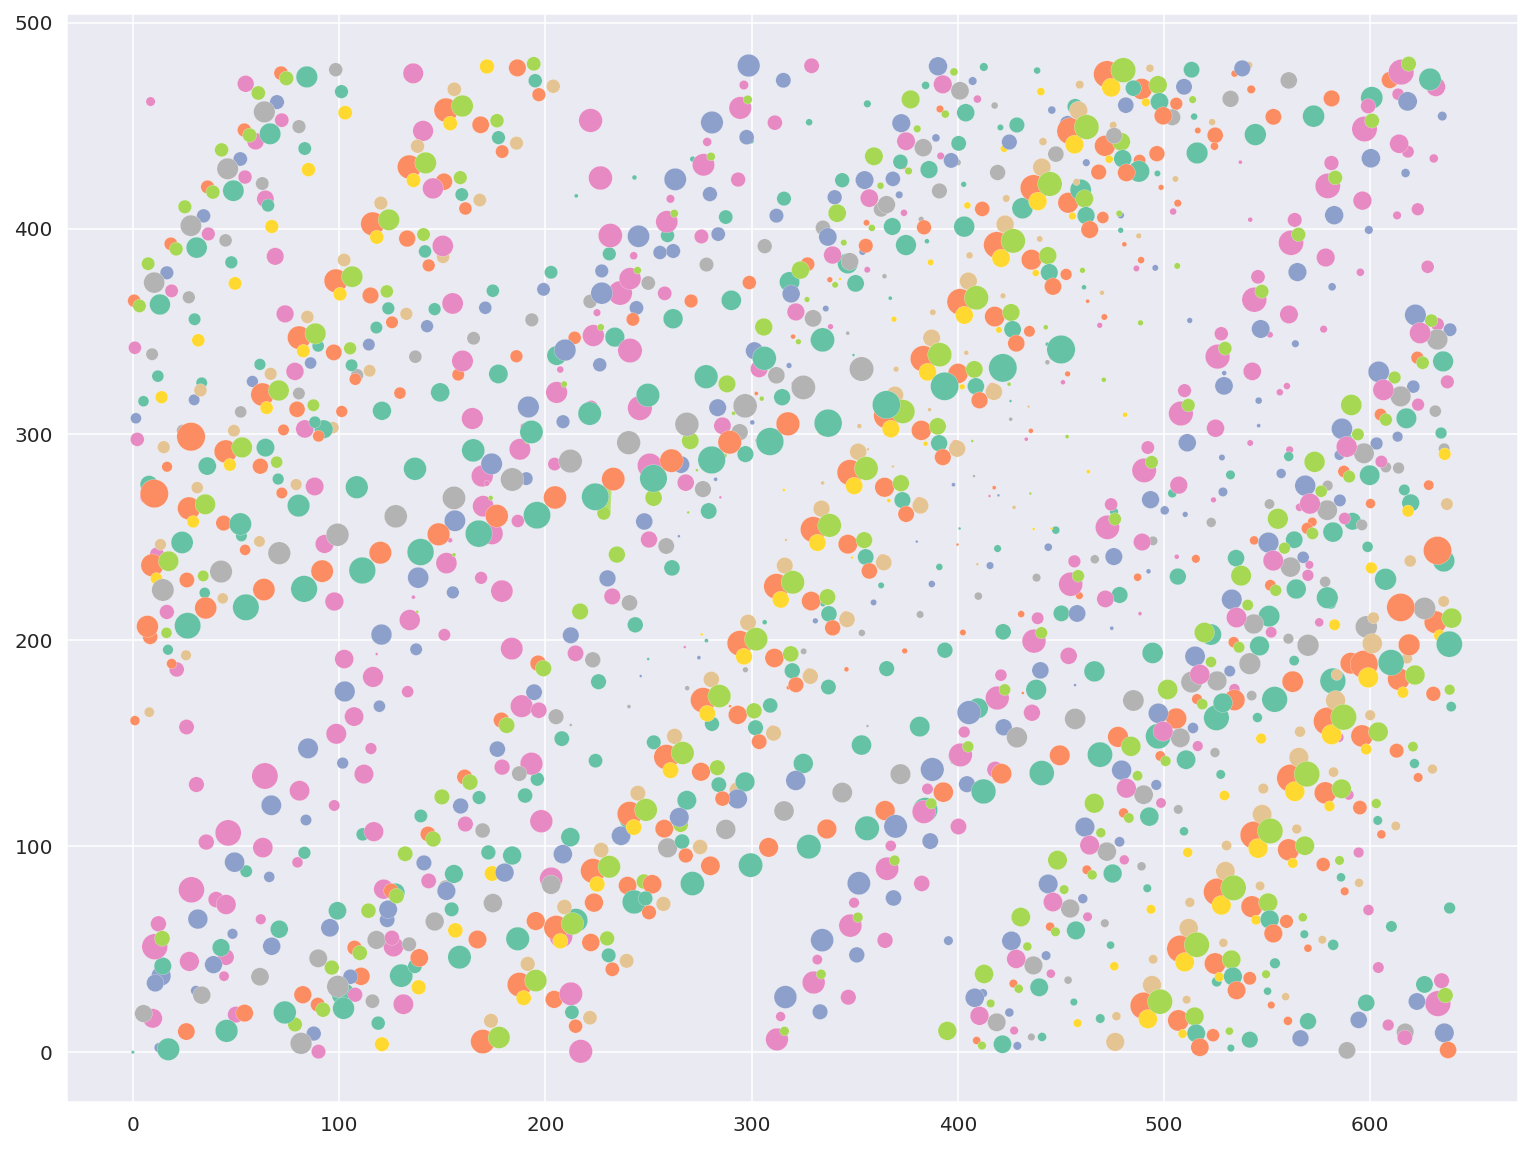

In [5]:
# visulization type (set to 0 to disable visualization)
visualization = 1

if visualization == 1:
  # Plot
  import seaborn as sns
  sns.set_style("darkgrid")

  plt.figure(figsize=(13, 10))
  sns.scatterplot(x = records[:, 0], y = records[:, 1],
                  s = (1+records[:, 5])*2, hue = records[:, 6],
                  legend=False, palette="Set2")
  plt.show()

elif visualization == 2:
  # Animation
  from matplotlib import animation

  # First set up the figure, the axis, and the plot element we want to animate
  fig = plt.figure(figsize=(6, 9))
  ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
  line, = ax.plot([], [], lw=2)

  # initialization function: plot the background of each frame
  def init():
      line.set_data([], [])
      return line,

  # animation function.  This is called sequentially
  def animate(i):
      x = np.linspace(0, 2, 1000)
      y = np.sin(2 * np.pi * (x - 0.01 * i))
      line.set_data(x, y)
      return line,

  # call the animator.  blit=True means only re-draw the parts that have changed.
  anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=200, interval=20, blit=True)
  
  anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
  plt.show()

### Obtain Training Data

In [ ]:
env = Environment(5)
X, Y, A, R = [], [], [], []

# simulate
for _ in tqdm(range(1000)):
  env = Environment(5)
  for _ in range(100):
    x = env.padded_state
    action = randint(0, 2)
    reward = env.step(action)
    if reward == -1:
      break

    # record
    X.append(x)
    A.append(action)
    Y.append(env.padded_state)
    R.append(reward)

# convert to numpy array
X = np.array(X)
Y = np.array(Y)
A = np.array(A)
R = np.array(R)
print(X.shape)
print(A.shape)

100%|██████████| 1000/1000 [00:31<00:00, 31.69it/s]


(67074, 100, 7)
(67074,)


In [ ]:
# save the data
np.save("X", X)
np.save("Y", Y)
np.save("A", A)
np.save("R", R)

## Original DETR Framework

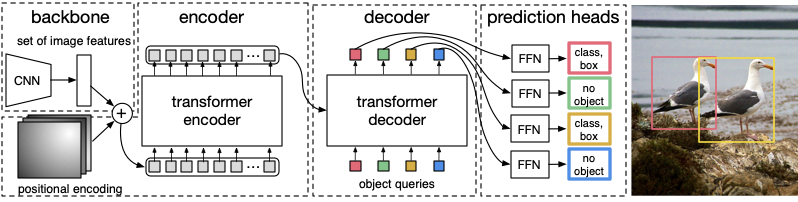

## DETR for set input
Framework of the original DETR



In [ ]:
class Set_DETR(nn.Module):
    """
    Set DETR implementation. Modified from DETR Demo.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, obj_len, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        # self.backbone = resnet50()
        # del self.backbone.fc

        # create conversion layer
        # self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # We no longer need the CNN preprocessing
        # However, we need an embedding layer
        self.input_set_embed = nn.Parameter(torch.rand(obj_len, hidden_dim))

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))


    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

## Inference

Current issue: Unlike the original DETR which has an fixed size array as the input, we have a variable length of set plus an integer (action) as input.

Should we separate the ways we use the two variables or not?